# Model Developement: KNN for Activity Recognition


## Feature Engineering
* Idea: spectral analysis!
* We sample @ fs = 50Hz -> Assumption: tracked movements have no frequency components > 5 Hz -> we can downsample the signal by a factor M = 3! -> we need an anti aliasing filter!

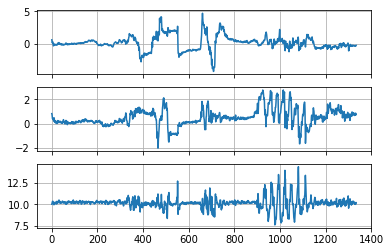

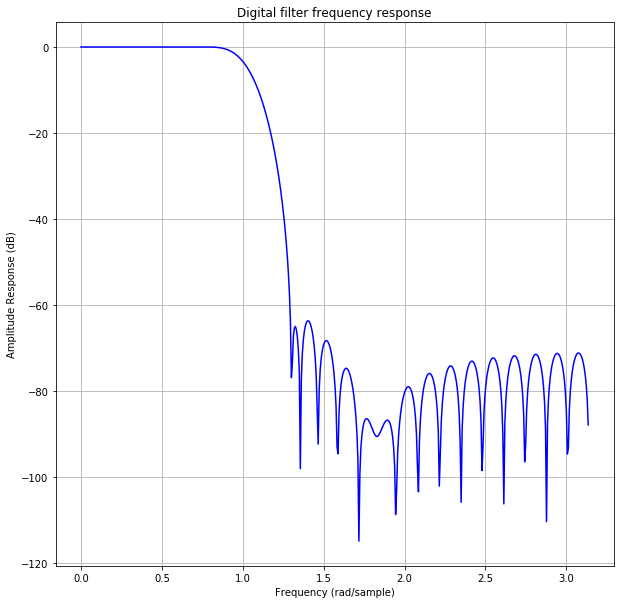

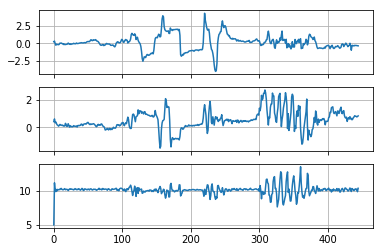

In [10]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import fftpack, signal
import pandas as pd

# load measurement data
with open('sevenSteps.txt', newline='\n') as dataFile:
    data = pd.read_csv(dataFile, ';')
    x = data.get_values()[:, 0]
    y = data.get_values()[:, 1]
    z = data.get_values()[:, 2]

# have a look at the data
plt.figure(figsize=(20, 20))
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.plot(x)
ax1.grid()
ax2.plot(y)
ax2.grid()
ax3.plot(z)
ax3.grid()

# design/apply anti aliasing filter and downsample the signals
M = 3  # downsampling factor
lowpass = signal.firwin(numtaps=48, cutoff=1 / M, window=('chebwin', -50))
w, H = signal.freqz(lowpass)
#print ("AA Filter Coefficients:", lowpass)
# for coeff in lowpass:
#     print(coeff,', ')


x = signal.convolve(x, lowpass, mode='same')
x = x[::M]

y = signal.convolve(y, lowpass, mode='same')
y = y[::M]

z = signal.convolve(z, lowpass, mode='same')
z = z[::M]

# have a look at the magnitude response of the aa filter
plt.figure(figsize=(10, 10))
plt.title('Digital filter frequency response')
plt.plot(w, 20 * np.log10(np.abs(H)), 'b')
plt.ylabel('Amplitude Response (dB)')
plt.xlabel('Frequency (rad/sample)')
plt.grid()
plt.show()

plt.figure()
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.plot(x)
ax1.grid()
ax2.plot(y)
ax2.grid()
ax3.plot(z)
ax3.grid()


27
[0.98872726 2.82636031 2.0486705  1.72062679 0.76241934 0.03824122]


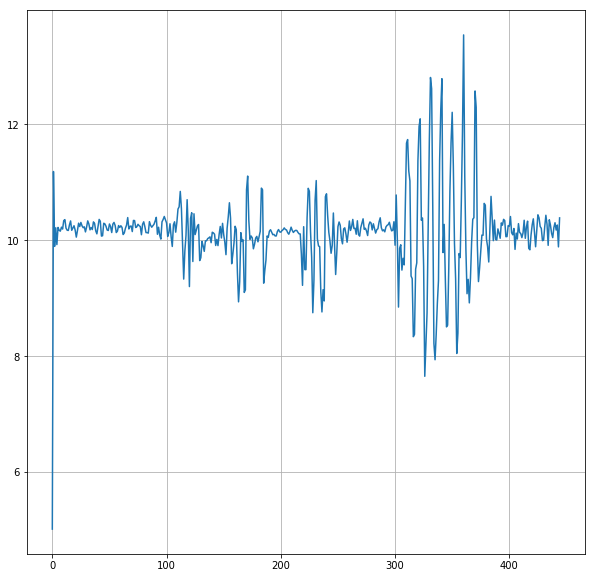

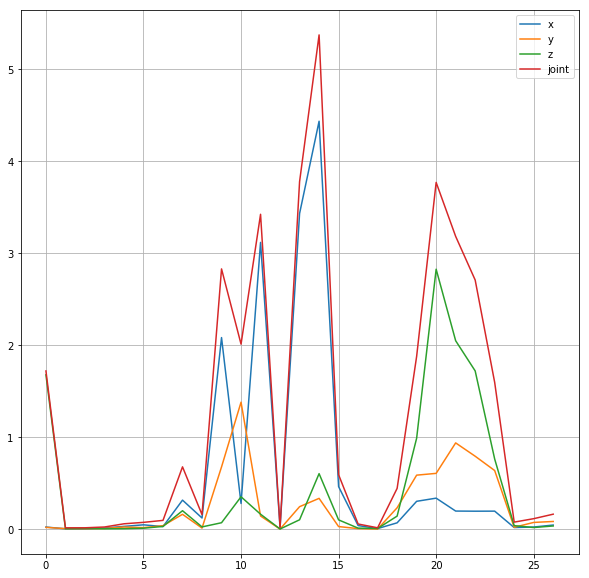

In [119]:
plt.figure(figsize=(10,10))
plt.plot(z)
plt.grid()

batchSize = 16
numBatches = int(np.floor(len(x) / batchSize))
print(numBatches)
xbatches = np.zeros((batchSize, numBatches))
ybatches = np.zeros((batchSize, numBatches))
zbatches = np.zeros((batchSize, numBatches))
for start in range(0,numBatches):
    xbatch = x[batchSize*start:batchSize*(start+1)]
    xbatches[:,start] = xbatch
    ybatch = y[batchSize*start:batchSize*(start+1)]
    ybatches[:,start] = ybatch
    zbatch = z[batchSize*start:batchSize*(start+1)]
    zbatches[:,start] = zbatch
    
    
xvar = np.var(xbatches,axis=0)
yvar = np.var(ybatches,axis=0)
zvar = np.var(zbatches,axis=0)

plt.figure(figsize=(10,10))
plt.plot(xvar)
plt.plot(yvar)
plt.plot(zvar)
plt.plot(xvar + yvar + zvar)
plt.legend(["x", "y", "z", "joint"])
plt.grid()

xbatches = xbatches - np.mean(xbatches, axis=0)
ybatches = ybatches - np.mean(ybatches, axis=0)
zbatches = zbatches - np.mean(zbatches, axis=0)

If we classify each second we get 50 / M = 17 samples! --> bad frequency resolution!! -> we take a Hann window for better practical frequency resolution!

[0.         0.26041667 0.52083333 0.78125    1.04166667 1.30208333
 1.5625     1.82291667 2.08333333 2.34375    2.60416667 2.86458333
 3.125      3.38541667 3.64583333 3.90625    4.16666667 4.42708333
 4.6875     4.94791667 5.20833333 5.46875    5.72916667 5.98958333
 6.25       6.51041667 6.77083333 7.03125    7.29166667 7.55208333
 7.8125     8.07291667]


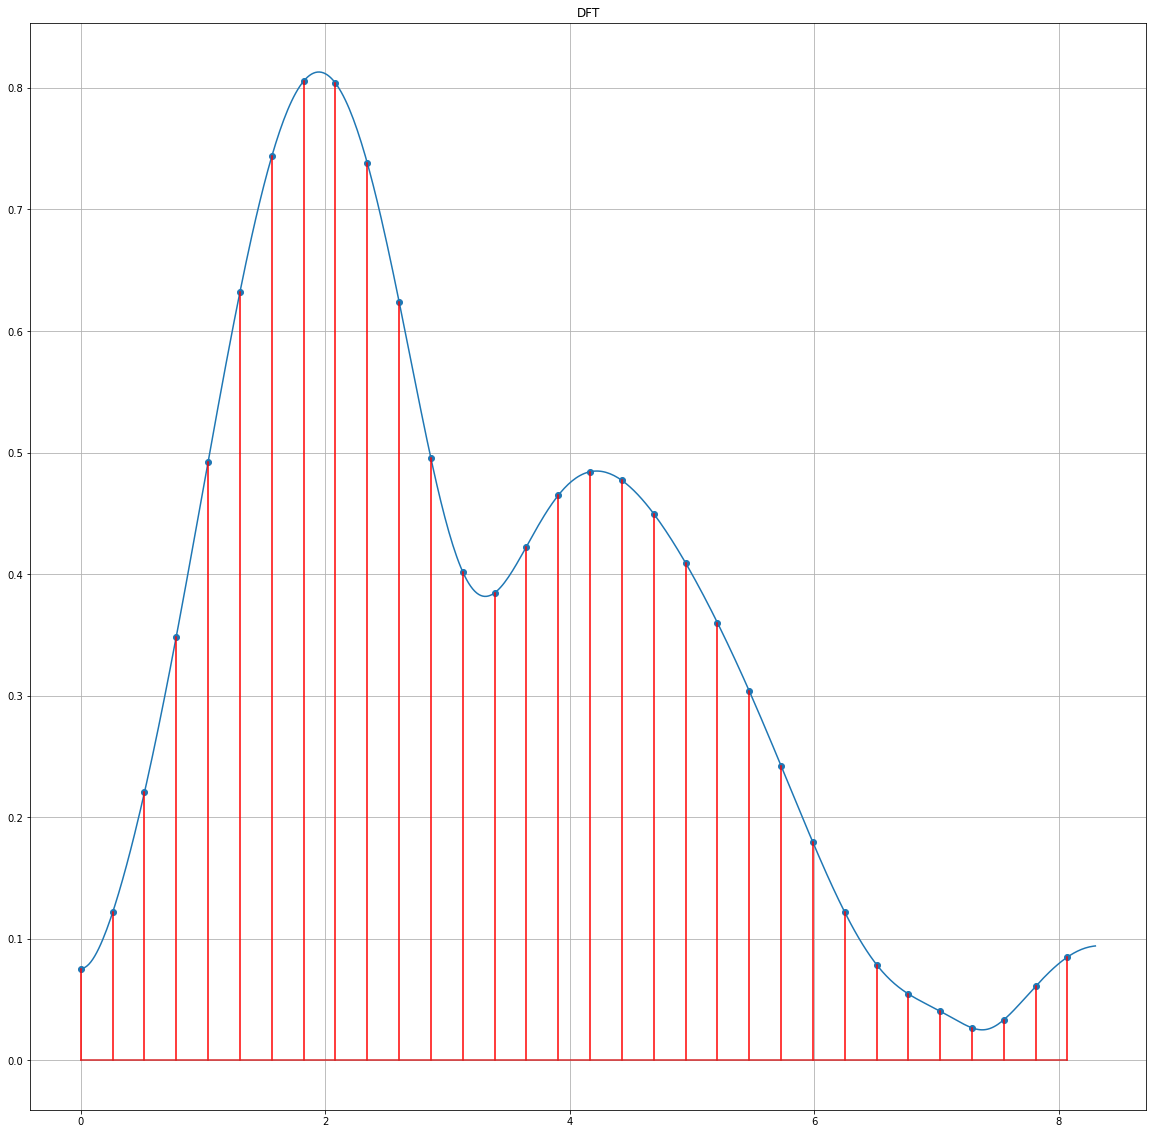

In [117]:
# sampling frequency in Hz
fs = 50 / M;

# generate and plot window
N = 16; # window length
n = np.arange(0, N, 1)
window = signal.get_window('hann', N)
#print ("Hann window coefficients: ", window)
# for coeff in window:
#     print(coeff,', ')

#plt.figure(figsize=(10, 10))
#plt.plot(n, window)
#plt.title('Hann Window for DFT Computation')


# compute DFT
NDFT = 1024;
x_test = zbatches[:,14] * window
X = fftpack.fft(x_test, NDFT)
X = X[: np.int(NDFT/2) - 1] # take only the onesided spectrum (for NDFT even!!!)
X *= 2 / np.sum(window) # do normalization

k = np.arange(0,NDFT/2 - 1, 1)
freq = k / (NDFT / 2) * fs / 2

fsampled = freq[::16]
magsampled = np.abs(X)[::16]
print(fsampled)
plt.figure(figsize=(20, 20))
plt.plot(freq, np.abs(X))
plt.stem(fsampled,magsampled, 'r')
plt.title('DFT')
plt.grid()